In [1]:
import fasttext
import pandas as pd
import re
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Funciones auxiliares

def clean_text_df(df, input_text_file='texto', stopwords=False):
    """
    Función para el procesamiento de texto
    1. pasa todo a minúscula
    2. elimina sitios web
    3. elimina puntuación
    4. elimins dígitos
    5. pasa todo a utf-8
    6. elimina espacios al inicip y al final
    7. elimina stopwords
    Devuelve archivo 0_data_proc.csv
    """
    text_raw = df[input_text_file]
    text_ed = text_raw.str.lower() # Pasa todo a minúsucula
    text_ed = text_ed.str.replace(r'^https?:\/\/.*[\r\n]*', r'_web_site_') # Elimina sitios web
    text_ed = text_ed.str.replace(r'[¡|¿|?|!|\'|"|#]',r'') # ELimina puntuación
    text_ed = text_ed.str.replace(r'[.|,|:|)|(|\|/]',r' ') # ELimina puntuación
    text_ed = text_ed.str.replace(r'[0-9]+',r'_digit_') # ELimina dígitos
    text_ed = text_ed.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    text_ed = text_ed.str.replace(r'\n', '').replace('\r', '') # Elimina espacios a izqueierda y derecha
    text_ed = text_ed.str.replace(r'  ', ' ').replace('   ', ' ').replace('    ', ' ')
    if stopwords == True:
        text_ed = text_ed.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    return(text_ed)


def predict_partial(X, layer):
    y_preds = []
    y_preds_proba = []
    for index, value in X.items():
        preds_ = layer.predict(value)
        preds = preds_[0][0]
        pred_proba = preds_[1][0]
        y_preds.append(preds)
        y_preds_proba.append(pred_proba)
    return(np.array(y_preds), np.array(y_preds_proba))


def predict_full(layer_0, layer_1, data, text_col='texto_ed'):
    X0 = data[text_col]
    
    y_preds_l0, y_preds_proba_l0 = predict_partial(X0, layer_0)
    #y_preds_final = np.array(["__label__NR" for i in range(len(y_preds_l0))]).astype('object')
    y_preds_final = np.copy(y_preds_l0).astype('object')
    
    y_preds_proba_final = y_preds_proba_l0
    
    filt = np.array([True if '__label__R' in i else False for i in y_preds_l0])
    
    X1 = data.loc[filt, text_col]
    y_preds_final[filt], y_preds_proba_final[filt] = predict_partial(X1, layer_1)
    return(y_preds_final,y_preds_proba_final)

# Modelo 1
- Capa 0: relevante, (no relevante, neutrales)
- Capa 1: positivo, negativo, necop `precisionAtRecall:30:__label__NEGATIVO`

## Carga modelos

In [3]:
model0 =fasttext.load_model('../models/final/0_train_pos_neg_necop.ftz')
model1 = fasttext.load_model('../models/final/1_train_pos_neg_necop_recprec30.ftz')

## Carga de datos

In [4]:
test = pd.read_csv('../data/data_final/test_pos_neg_necop.csv',lineterminator='\n')
test = test[['texto', 'texto_ed', 'etiqueta_etapa0', 'etiqueta_final']]

In [5]:
test.loc[:,'etiqueta_final'] = test['etiqueta_final'].replace({'NR':'__label__NR',
                                                               'NECOP':'__label__NECOP',
                                                               'NEUTRAL':'__label__NR',
                                                               'POSITIVO': '__label__POSITIVO',
                                                               'NEGATIVO':'__label__NEGATIVO'})

test.loc[:,'etiqueta_etapa0'] = test['etiqueta_etapa0'].replace({'NR':'__label__NR',
                                                               'R':'__label__R'})

In [6]:
y_test_preds, y_test_proba = predict_full(layer_0=model0,
                                          layer_1=model1,
                                          data=test,
                                          text_col='texto_ed')

In [7]:
labs = np.sort(test['etiqueta_final'].unique())
report = pd.DataFrame(classification_report(test['etiqueta_final'], y_test_preds, output_dict=True))
report.drop('support', axis=0, inplace=True)
conf = pd.DataFrame(confusion_matrix(test['etiqueta_final'], y_test_preds), index=labs)

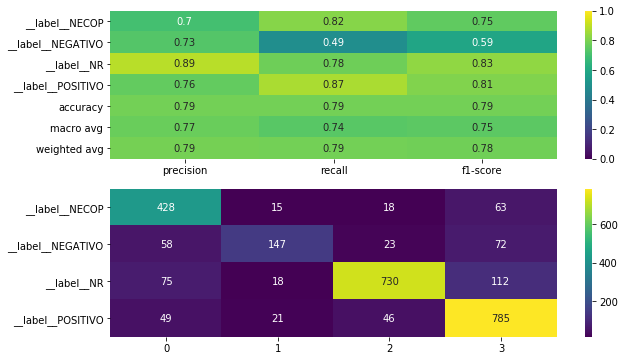

In [8]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")

### Performance en pos-neg

In [9]:
test_pos_neg = test[test['etiqueta_final'] != '__label__NR']

In [10]:
y_preds_pos_neg = [model1.predict(i)[0][0] for i in test_pos_neg['texto_ed'].values]

In [11]:
labs = np.sort(test_pos_neg['etiqueta_final'].unique())
report = pd.DataFrame(classification_report(test_pos_neg['etiqueta_final'], y_preds_pos_neg, output_dict=True))
report.drop('support', axis=0, inplace=True)
conf = pd.DataFrame(confusion_matrix(test_pos_neg['etiqueta_final'], y_preds_pos_neg), index=labs)

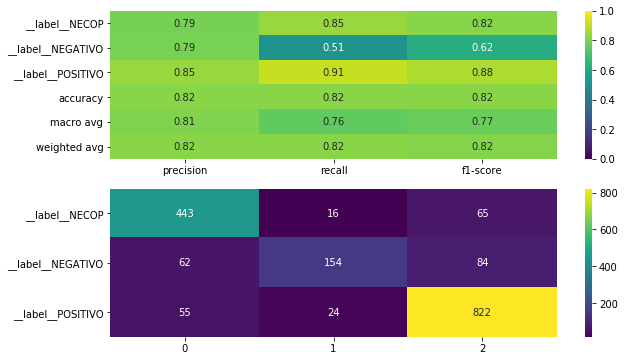

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")

# Modelo 2
- Capa 0: relevante, no relevante, 
- Capa 1: positivo, negativo `precisionAtRecall:30:__label__NEGATIVO`, necesidades operativas


In [4]:
model01 =fasttext.load_model('../models/final/0_train_necop_pos_neg.ftz')
model11 = fasttext.load_model('../models/final/1_train_necop_pos_neg_recprec30.ftz')

In [5]:
test2 = pd.read_csv('../data/data_final/test_necop_pos_neg.csv',lineterminator='\n')
test2 = test2[['texto', 'texto_ed', 'etiqueta_etapa0', 'etiqueta_final']]

In [6]:
test2.etiqueta_final.value_counts()

POSITIVO    905
NR          624
NECOP       526
NEGATIVO    298
NEUTRAL     227
Name: etiqueta_final, dtype: int64

In [15]:
test2.loc[:,'etiqueta_final'] = test2['etiqueta_final'].replace({'NR':'__label__NR',
                                                               'NECOP':'__label__NECOP',
                                                               'NEUTRAL':'__label__NR',
                                                               'POSITIVO': '__label__POSITIVO',
                                                               'NEGATIVO':'__label__NEGATIVO'})

test2.loc[:,'etiqueta_etapa0'] = test2['etiqueta_etapa0'].replace({'NR':'__label__NR',
                                                                   'R':'__label__R',
                                                                   'NECOP': '__label__NECOP'
                                                                  })

In [16]:
y_test_preds, y_test_proba = predict_full(layer_0=model01,
                                          layer_1=model11,
                                          data=test2,
                                          text_col='texto_ed')

In [17]:
labs = np.sort(test2['etiqueta_final'].unique())
report = pd.DataFrame(classification_report(test2['etiqueta_final'], y_test_preds, output_dict=True))
report.drop('support', axis=0, inplace=True)
#report.drop('label_NECOP', axis=1, inplace=True)
conf = pd.DataFrame(confusion_matrix(test2['etiqueta_final'], y_test_preds))
conf.index = labs

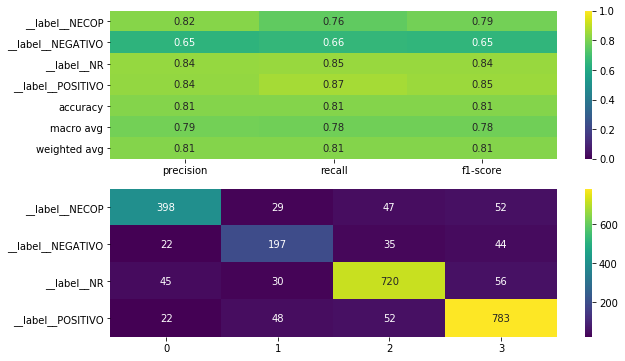

In [18]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")

### Performance en R-NR-NECOP

In [19]:
test_r_nr = test2[test2['etiqueta_final'] != '__label__R']
y_preds_r_nr  = [model01.predict(i)[0][0] for i in test_r_nr['texto_ed'].values]

In [20]:
labs = np.sort(test_r_nr['etiqueta_etapa0'].unique())
report = pd.DataFrame(classification_report(test_r_nr['etiqueta_etapa0'], y_preds_r_nr, output_dict=True))
conf = pd.DataFrame(confusion_matrix(test_r_nr['etiqueta_etapa0'], y_preds_r_nr))

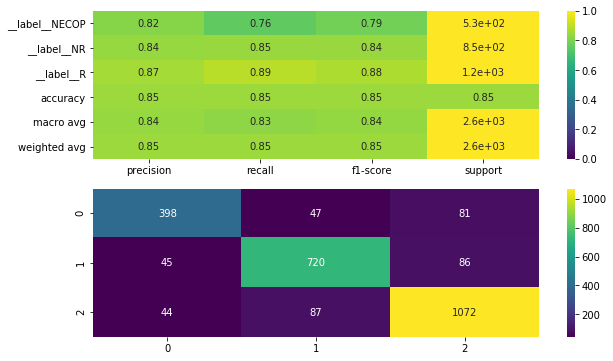

In [21]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")

### Performance en posneg

In [22]:
test_pos_neg = test2[test2['etiqueta_final'] != '__label__NR']
y_preds_pos_neg = [model11.predict(i)[0][0] for i in test_pos_neg['texto_ed'].values]

In [23]:
labs = np.sort(test_pos_neg['etiqueta_final'].unique())
report = pd.DataFrame(classification_report(test_pos_neg['etiqueta_final'], y_preds_pos_neg, output_dict=True))
report.drop('support', axis=0, inplace=True)
report.drop('__label__NECOP', axis=1, inplace=True)
conf = pd.DataFrame(confusion_matrix(test_pos_neg['etiqueta_final'], y_preds_pos_neg), index=labs)

/home/grosati/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


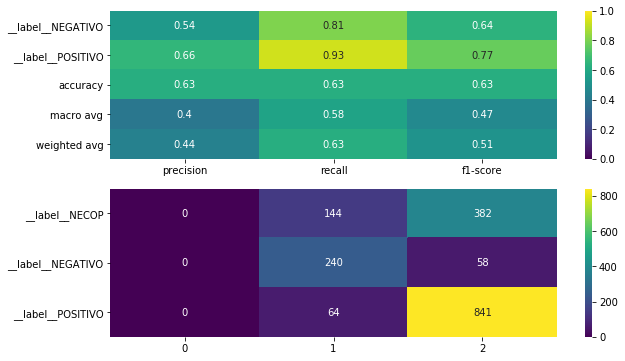

In [24]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")

## Modelo 3

- Capa 0: relevante, no relevante (no relevante, neutro, positivo), 
- Capa 1: necesidades operativas, negativo `precisionAtRecall:30:__label__NEGATIVO`


In [25]:
model02 =fasttext.load_model('../models/final/0_train_neg_necop.ftz')
model12 = fasttext.load_model('../models/final/1_train_neg_necop_recprec30.ftz')

In [26]:
test3 = pd.read_csv('../data/data_final/test_neg_necop.csv',lineterminator='\n')
test3 = test3[['texto', 'texto_ed', 'etiqueta_etapa0', 'etiqueta_final']]

In [27]:
test3.loc[:,'etiqueta_final'] = test3['etiqueta_final'].replace({'NR':'__label__NR',
                                                               'NECOP':'__label__NECOP',
                                                               'NEUTRAL':'__label__NR',
                                                               'POSITIVO': '__label__NR',
                                                               'NEGATIVO':'__label__NEGATIVO'})

test3.loc[:,'etiqueta_etapa0'] = test3['etiqueta_etapa0'].replace({'NR':'__label__NR',
                                                               'R':'__label__R'})

In [28]:
y_test_preds, y_test_proba = predict_full(layer_0=model02,
                                          layer_1=model12,
                                          data=test3,
                                          text_col='texto_ed')

In [29]:
labs = np.sort(test3['etiqueta_final'].unique())
report = pd.DataFrame(classification_report(test3['etiqueta_final'], y_test_preds, output_dict=True))
report.drop('support', axis=0, inplace=True)
conf = pd.DataFrame(confusion_matrix(test3['etiqueta_final'], y_test_preds), index=labs)

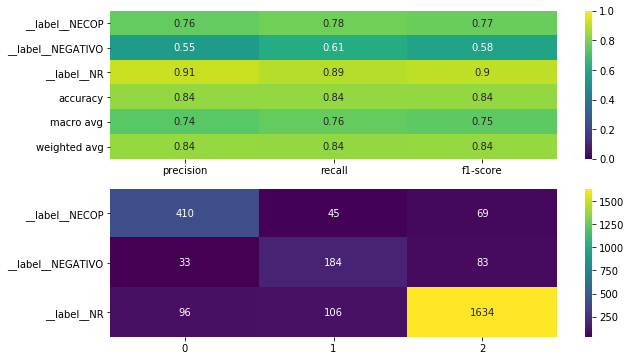

In [30]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")

In [31]:
test_pos_neg = test3[test3['etiqueta_final'] != '__label__NR']
y_preds_pos_neg = [model12.predict(i)[0][0] for i in test_pos_neg['texto_ed'].values]

In [32]:
labs = np.sort(test_pos_neg['etiqueta_final'].unique())
report = pd.DataFrame(classification_report(test_pos_neg['etiqueta_final'], y_preds_pos_neg, output_dict=True))
report.drop('support', axis=0, inplace=True)
report.drop('__label__NECOP', axis=1, inplace=True)
conf = pd.DataFrame(confusion_matrix(test_pos_neg['etiqueta_final'], y_preds_pos_neg), index=labs)

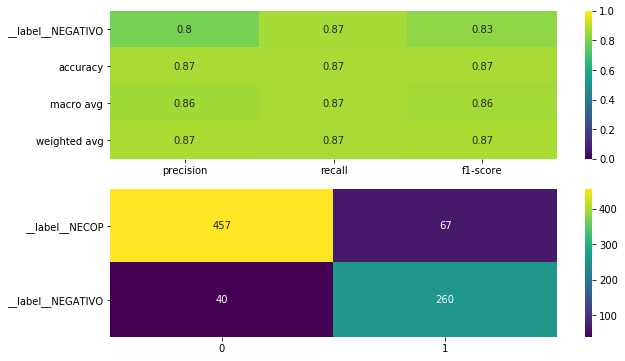

In [33]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.heatmap(report.T, annot=True, vmin=0, vmax=1, cmap="viridis")
plt.subplot(2,1,2)
sns.heatmap(conf, annot=True, cmap="viridis", fmt="d")